# 3.1 Motion through pose composition

A fundamental aspect of the development of mobile robots is the motion itself. In an idyllic world, motion commands are sent to the robot locomotion system, which perfectly executes them and drives the robot to a desired location. However, this is not a trivial matter, as many sources of motion error appear: 
- wheel slippage, 
- inaccurate calibration,
- temporal response of motors,
- limited resolution during integration (time increments, measurement resolution), or
- unequal floor, among others.

These factors introduce uncertainty in the robot motion. Additionally, other constraints to the movement difficult its implementation. 

After executing a motion command, the robot would end up in a different position/orientation from the initial one. This particular chapter explores the concept of *robot's pose* used to represent these positions/orientations, and how we deal with it in a probabilistic context.

The pose itself can take multiple forms depending on the problem context:

- **2D location**: In a planar context we only need to a 2d vector $[x, y]^T$ to locate a robot against a point of reference, the origin $(0, 0).$
- **2D pose**: In most cases involving mobile robots, the location alone is insufficient. We need an additional parameter known as orientation or *bearing*. Therefore, a robot's pose is usually expressed as $[x, y, \theta]^T$ (see Fig. 1). *In the rest of the book, we mostly refer to this one.*
- **3D pose**: Although we will only mention it in passing, for robotics applications in the 3D space, *i.e.* UAV or drones, not only a third axis $z$ is added, but to handle the orientation in a 3D environment we need 3 components, *i.e.* roll, pitch and yaw. This course is centered around planar mobile robots so we will not use this one, nevertheless most methods could be adapted to 3D environments.

In this chapter we will explore how to use the **composition of poses** to express poses in a certain reference system, while the next two chapters describe two probabilistic methods for dealing with the uncertainty inherent to robot motion, namely the **velocity-based** motion model and the **odometry-based** one. 

# Notebook context: move that robot!

The figure below shows a Giraff robot, equipped with a rig of RGB-D sensors and a 2D laser scanners. The robot is gathering information from said sensors to collect a dataset. Datasets are useful to train and test new techniques for navigation, perception, etc. However, if the robot remains static, the dataset will only contain information about the part of the room that it is currently inspecting, so, we need to move it!

<figure style="text-align:center">
  <img src="images/robot_giraff_mapir.jpg" alt="" width="400px">
</figure>

Your task in this notebook will be to command the robot to move through the environment and calculate its new position after executing a motion command. Let's go!

In [1]:
%matplotlib widget

# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, clear_output
import time

import sys
sys.path.append("..")
from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp

## <span style="color:green">OPTIONAL</span>

<span style="color:green">In the Robot motion lecture, we started talking about *Differential drive* motion systems. Include as many cells as needed to introduce the background that you find interesting about it and some code illustrating some related aspect, for example, a code computing and plotting the *Instantaneus Center of Rotation (ICR)* according to a number of given parameters.</span>

<span style="color:green">***END OF OPTIONAL PART***</span>

## 3.1 Pose composition <a id="pose_composition"></a>

The composition of posses is a tool that permits us to express the *final* pose of a robot in an arbitrary coordinate system. Given an initial pose $p_1$ and a pose differential $\Delta p$ (pose increment), *i.e.* how much the robot has moved during an interval of time, the final pose $p$ can be computed using the **composition of poses** function (see Fig.1):

$$
    p_1 = 
        \begin{bmatrix}
            x_1 \\ y_1 \\ \theta_1
        \end{bmatrix}, \, \, \,
    \Delta p = 
        \begin{bmatrix}
            \Delta x \\ \Delta y \\ \Delta \theta
        \end{bmatrix}
$$

$$
    \begin{equation}
    p_2 = \begin{bmatrix}
            x \\ y \\ \theta
        \end{bmatrix}
        = p_1 \oplus \Delta p
        = \begin{bmatrix}
            x_1 + \Delta x \cos \theta_1 - \Delta y \sin \theta_1 \\ 
            y_1 + \Delta x \sin \theta_1 + \Delta y \cos \theta_1 \\
            \theta_1 + \Delta \theta
          \end{bmatrix}
    \end{equation}
$$

<figure style="text-align:center">
  <img src="images/pose-composition.png" alt="" width="400px">
  <figcaption>Fig. 1: Example of an initial 2D robot pose ($p_1$) and its resultant pose ($p_2$) after completing a motion ($\Delta p$).</figcaption>
</figure>

The differential $\Delta p$, although we are using it as control in this exercise, normally is calculated given the robot's locomotion or sensed by the wheel encoders.

You are provided with a function called `pose_2 = tcomp(pose_1,u)` that apply the composition of poses to pose `pose_1`and pose increment `u` and returns the new pose `pose_2`. Below you have a code cell to play with it.

Initial pose: [[0]
 [0]
 [0]]
Pose increment: [[2.        ]
 [2.        ]
 [1.57079633]]
New pose after applying tcomp: [[2.        ]
 [2.        ]
 [1.57079633]]


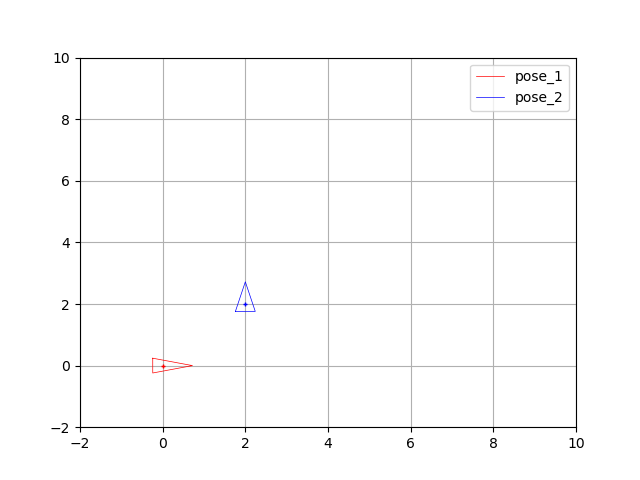

In [2]:
# Pose increments' playground!

# You can modify pose and increment here to experiment
pose_1 = np.vstack([0, 0, 0])  # Initial pose 
u = np.vstack([2, 2, np.pi/2])  # Pose increment 
pose_2 = tcomp(pose_1, u) # Pose after executing the motion

# NUMERICAL RESULTS
print(f"Initial pose: {pose_1}")
print(f"Pose increment: {u}")
print(f"New pose after applying tcomp: {pose_2}")

# VISUALIZATION
fig, ax = plt.subplots()
plt.grid('on')
plt.xlim((-2, 10))
plt.ylim((-2, 10))
h1 = DrawRobot(fig, ax, pose_1);
h2 = DrawRobot(fig, ax, pose_2, color='blue')
plt.legend([h1[0],h2[0]],['pose_1','pose_2']);

## <span style="color:green">OPTIONAL</span>

<span style="color:green">Implement your own methods to compute the composition of two poses, as well as the inverse composition. Include some examples of their utilization, also incorporating plots.</span>

<span style="color:green">***END OF OPTIONAL PART***</span>

### **<span style="color:green"><b><i>ASSIGNMENT 1: Moving the robot by composing pose increments</i></b></span>**

Take a look at the `Robot()` class provided and its methods: the constructor, `step()` and `draw()`. Then, modify the main function in the next cell for the robot to describe a $8m \times 8m$ square path as seen in the figure below. You must take into account that:

- The robot starts in the bottom-left corner $(0, 0)$ heading north and 
- moves at increments of $2 m$ each step. 
- Each 4 steps, it will turn right.

**Example**


<figure style="text-align:center">
  <img src="images/fig3-1-1.png" alt="">
  <figcaption>Fig. 2: Route of our robot.</figcaption>
</figure>

In [3]:
class Robot():
    '''Mobile robot implementation
    
        Attr:
            pose: Expected position of the robot
    '''
    def __init__(self, mean):
        self.pose = mean

    def step(self, u):
        self.pose = tcomp(self.pose, u)
    
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

In [4]:
def main(robot):
    
    # PARAMETERS INITIALIZATION
    num_steps = 15 # Number of robot motions
    turning = 4  # Number of steps for turning
    u = np.vstack([2., 0., 0.]) # Motion command (pose increment)
    angle_inc = -np.pi/2 # Angle increment
    
    # VISUALIZATION
    fig, ax = plt.subplots()
    plt.ion()
    plt.draw()
    plt.xlim((-2, 10))
    plt.ylim((-2, 10))
    plt.fill([2, 2, 6, 6],[2, 6, 6, 2],facecolor='lightgray', edgecolor='gray', linewidth=3)
    
    plt.grid()
    robot.draw(fig, ax)
    
    # MAIN LOOP
    for step in range(1,num_steps+1):
        
        # Check if the robot has to move in straight line or also has to turn
        # and accordingly set the third component (rotation) of the motion command 
        if not step % turning == 0: #cuando giro que ángulo tenego que girar
            u[2] = 0
        else:
            u[2] = u[2]+angle_inc
             
        # Execute the motion command        
        robot.step(u)
        
        # VISUALIZATION        
        robot.draw(fig, ax)        
        clear_output(wait=True)
        display(fig)        
        time.sleep(0.1)
        
    plt.close()

Execute the following code cell to **try your code**. The resulting figure must be the same as Fig. 2.

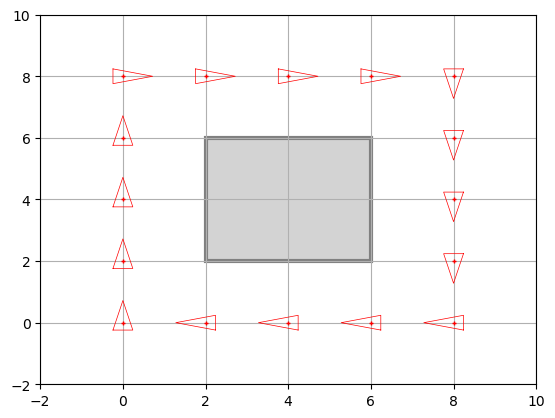

In [5]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
robot = Robot(initial_pose)
main(robot)

## 3.2 Considering noise

In the previous case, the robot motion was error-free. This is overly optimistic as in a real use case the conditions of the environment and the motion itselft are a huge source of uncertainty.

To take into consideration such uncertainty, we will model the movement of the robot as a (multidimensional) gaussian distribution $\Delta p \sim N(\mu_{\Delta p},\Sigma_{\Delta p})$ where:

- The mean $\mu_{\Delta p}$ is still the pose differential in the previous exercise, that is $\Delta p_{\text{given}}$.
- The covariance $\Sigma_{\Delta p}$ is a $3 \times 3$ matrix, which defines the amount of error at each step (time interval). It looks like this:
$$ 
\Sigma_{\Delta p}  =
        \begin{bmatrix}
            \sigma_x^2 & 0 & 0 \\
            0 & \sigma_y^2 & 0 \\
            0 & 0 & \sigma_\theta^2
        \end{bmatrix}
        $$

To gain insight into the vocariance matrix, let's suppose that we've commanded Giraff to move two meters forward, one to the left, and turns pi/2 to the left a total of twenty times, and we've measured its final position. This is the result: 

In [6]:
# Array of motion measurements [x_i,y_i,theta_i]
data = np.array([
    [1.9272377,  0.61826959, 1.56767043],
    [2.32512511, 1.00742,    1.5908133],
    [2.18640042, 0.98655067, 1.68010124],
    [1.98890723, 0.96641266, 1.5478623],
    [2.0729443,  0.82685635, 1.67115959],
    [1.975565,   1.20433306, 1.62406736],
    [1.88160001, 1.17310891, 1.54204513],
    [2.21991591, 0.92045473, 1.55294863],
    [1.79006882, 0.97170525, 1.60347324],
    [2.13932179, 1.17665025, 1.57022972],
    [1.89099453, 0.86546558, 1.52364342],
    [1.78903666, 0.93264142, 1.60133537],
    [2.05418773, 1.34436849, 1.58577607],
    [2.12027142, 1.15626879, 1.5552685],
    [2.04842395, 1.22015604, 1.58246969],
    [2.00209448, 0.77744971, 1.55656092],
    [2.06276761, 0.88401541, 1.62989382],
    [1.70384096, 1.12819609, 1.61440142],
    [1.84918712, 1.26022099, 1.50058668],
    [2.02138316, 1.12614774, 1.52156016]
])

### **<span style="color:green"><b><i>ASSIGNMENT 2: Calculating the covariance matrix</i></b></span>**

Complete the following code to compute the covariance matrix characterizing the motion uncertainty of the Giraff robot. Ask yourself what the values in the diagonal mean, and what happens if they increase/decrease.

*Hints: `np.var()`, `np.diag()`*

Covariance matrix:
[[0.02342594 0.         0.        ]
 [0.         0.03246639 0.        ]
 [0.         0.         0.00212976]]


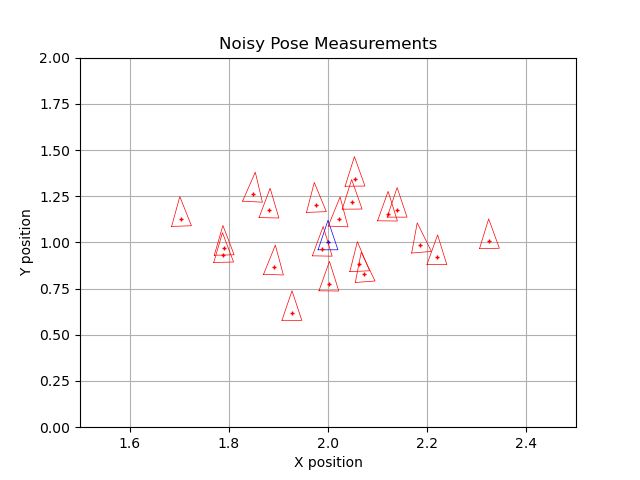

In [7]:
# Compute the covariance matrix (since there is no correlation, we only compute variances)
cov_x = np.var(data[:,0])
cov_y = np.var(data[:,1])
cov_theta = np.var(data[:,2])

# Form the diagonal covariance matrix
covariance_matrix = np.diag([cov_x, cov_y, cov_theta])

# PRINT COVARIANCE MATRIX
print("Covariance matrix:")
print(covariance_matrix)

# VISUALIZATION
fig, ax = plt.subplots()
plt.xlim((1.5, 2.5))
plt.ylim((0, 2))
plt.grid('on')
# Commanded pose
DrawRobot(fig, ax, np.vstack([2, 1, np.pi/2]), color='blue')
# Noisy poses
for pose in data:
    DrawRobot(fig, ax, np.vstack([pose[0],pose[1],pose[2]]))
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Noisy Pose Measurements')
plt.show()

<span style="color:blue">Expected results:</span>

```
Covariance matrix:
[[0.02342594 0.         0.        ]
 [0.         0.03246639 0.        ]
 [0.         0.         0.00212976]]
```

### **<span style="color:green"><b><i>ASSIGNMENT 3: Adding noise to the pose motion</i></b></span>**

Now, we are going to add a Gaussian noise to the motion, assuming that the incremental motion now follows the probability distribution:

$$
    \Delta p = N(\Delta p_{given}, \Sigma_{\Delta p})
    \textit{ with } 
    \Sigma_{\Delta p}  =
        \begin{bmatrix}
            0.04 & 0 & 0 \\
            0 & 0.04 & 0 \\
            0 & 0 & 0.01
        \end{bmatrix}
    (\text{ units in }m^2 \text{ and } rad^2)
$$

For doing that, complete the `NosyRobot()` class below, which is a child class of the previous `Robot()` one. Concretely, you have to:

- Complete this new class by adding some amount of noise to the movement (take a look at the `step()` method. *Hints: [`np.vstack()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html), [`stats.multivariate_normal.rvs()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html)*. 
- Remark that we have now two variables related to the robot pose:
  - `self.pose`, which represents the expected, *ideal* pose, and
  - `self.true_pose`, that stands for the actual pose after carrying out a noisy motion command.
- Along with the expected pose drawn in red (`self.pose`), in the `draw()` method plot the real pose of the robot (`self.true_pose`) in blue, which as commented is affected by noise. 

Run the cell several times to see that the motion (and the path) is different each time. Try also with different values of the covariance matrix.

**Example**

<figure style="text-align:center">
  <img src="images/fig3-1-2.png" alt="">
  <figcaption>Fig. 3: Movement of our robot using pose compositions. <br/>
      Containing the expected poses (in red) and the true pose <br/> affected by noise (in blue)</figcaption>
</figure>

In [15]:
class NoisyRobot(Robot):
    """Mobile robot implementation. It's motion has a set ammount of noise.
    
        Attr:
            pose: Inherited from Robot
            true_pose: Real robot pose, which has been affected by some ammount of noise.
            covariance: Amount of error of each step.
    """
    def __init__(self, mean, covariance):
        super().__init__(mean)
        self.true_pose = mean
        self.covariance = covariance
        
    def step(self, step_increment):
        """Computes a single step of our noisy robot.
        
            super().step(...) updates the expected pose (without noise)
            Generate a noisy increment based on step_increment and self.covariance.
            Then this noisy increment is applied to self.true_pose
        """
        "step increment es el paso ideal (media distribución normal)"
        super().step(step_increment)
        true_step = stats.multivariate_normal.rvs(step_increment.flatten(), np.vstack(self.covariance))
        self.true_pose = tcomp(self.true_pose, np.vstack(true_step)) 
        
    def draw(self, fig, ax): 
        super().draw(fig, ax)
        DrawRobot(fig, ax, self.true_pose, color='blue')

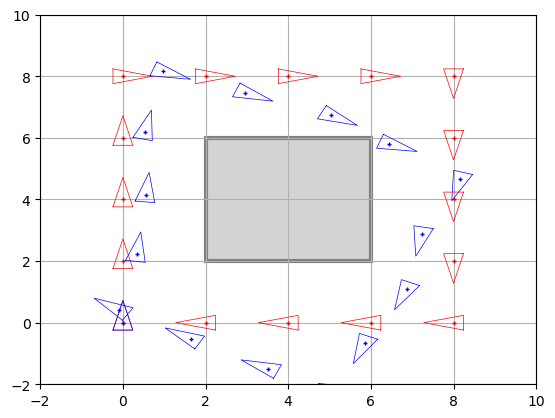

In [17]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
cov = np.diag([0.04, 0.04, 0.01])  

robot = NoisyRobot(initial_pose, cov)
main(robot)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now that you are an expert in retrieving the pose of a robot after carrying out a motion command defined as a pose increment, **answer the following questions**:

- Why are the expected (red) and true (blue) poses different?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

- In which scenario could they be the same?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- How affect the values in the covariance matrix $\Sigma_{\Delta p}$ the robot motion?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>